### 1. Create Experiment

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import azureml
from azureml.core import Workspace, Run

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.0.2


In [2]:
# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, ws.location, sep = '\t')

Found the config file in: /home/nbuser/library/config.json
seank-ml	westus2	SeanK-ML	westus2


In [3]:
experiment_name = 'sklearn-mnist'

from azureml.core import Experiment
exp = Experiment(workspace=ws, name=experiment_name)

### 2. Train Model

In [4]:
import os
import urllib.request

os.makedirs('./data', exist_ok = True)

urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', filename='./data/train-images.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', filename='./data/train-labels.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', filename='./data/test-images.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', filename='./data/test-labels.gz')

('./data/test-labels.gz', <http.client.HTTPMessage at 0x7fe47b6625f8>)

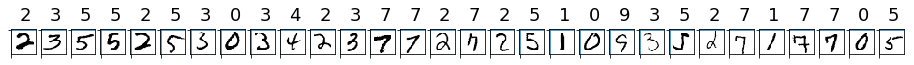

In [5]:
# make sure utils.py is in the same directory as this code
from utils import load_data

# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the model converge faster.
X_train = load_data('./data/train-images.gz', False) / 255.0
y_train = load_data('./data/train-labels.gz', True).reshape(-1)

X_test = load_data('./data/test-images.gz', False) / 255.0
y_test = load_data('./data/test-labels.gz', True).reshape(-1)

# now let's show some randomly chosen images from the traininng set.
count = 0
sample_size = 30
plt.figure(figsize = (16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x=10, y=-10, s=y_train[i], fontsize=18)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.Greys)
plt.show()

In [6]:
%%time
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train, y_train)

CPU times: user 1min 54s, sys: 2.46 s, total: 1min 57s
Wall time: 1min 57s


In [7]:
y_hat = clf.predict(X_test)
print(np.average(y_hat == y_test))

0.9201


### 3. Upload Model

In [8]:
import os

from sklearn.externals import joblib

os.makedirs('outputs', exist_ok=True)
# note file saved in the outputs folder is automatically uploaded into experiment record
joblib.dump(value=clf, filename='outputs/sklearn_mnist_model.pkl')

['outputs/sklearn_mnist_model.pkl']

In [10]:
from azureml.core.model import Model

model = Model.register(model_path = "outputs/sklearn_mnist_model.pkl",
                       model_name = "Mymodel",
                       description = "test",
                       workspace = ws)

Registering model Mymodel


### 4. Create Container

In [16]:
%%writefile score.py
import json
import numpy as np
import os
import pickle
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression

from azureml.core.model import Model

def init():
    global model
    # retreive the path to the model file using the model name
    model_path = Model.get_model_path('Mymodel')
    model = joblib.load(model_path)

def run(raw_data):
    data = json.loads(raw_data)
    # data = np.array(json.loads(raw_data)['data'])
    # make prediction
    # y_hat = model.predict(data)
    out = { 'input': data, 'output': 45}
    return json.dumps(out)

Writing score.py


In [17]:
from azureml.core.conda_dependencies import CondaDependencies 

myenv = CondaDependencies()
myenv.add_conda_package("scikit-learn")

with open("myenv.yml","w") as f:
    f.write(myenv.serialize_to_string())

In [18]:
with open("myenv.yml","r") as f:
    print(f.read())

# Conda environment specification. The dependencies defined in this file will
# be automatically provisioned for runs with userManagedDependencies=False.

# Details about the Conda environment file format:
# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually

name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2

- pip:
    # Required packages for AzureML execution, history, and data preparation.
  - azureml-defaults
- scikit-learn



In [19]:
from azureml.core.image import ContainerImage

# Image configuration
image_config = ContainerImage.image_configuration(execution_script = "score.py",
                                                 runtime = "python",
                                                 conda_file = "myenv.yml",
                                                 description = "dummy model",
                                                 tags = {"data": "any", "type": "regression"}
                                                 )

In [20]:
# Create the image from the image configuration
image = ContainerImage.create(name = "myimage", 
                              models = [model], #this is the model object
                              image_config = image_config,
                              workspace = ws
                              )

Creating image
